## Установка библиотек

In [1]:
# !pip install pytorch-transformers

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [3]:
import json
import re

In [5]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    torch.cuda.set_device(1)
    print(torch.cuda.get_device_name(1), torch.cuda.current_device())

NVIDIA GeForce RTX 2080 Ti 1


## Загрузка данных


In [6]:
with open('data/full_docs.json', 'r+') as fp:
    full_docs1 = json.load(fp)

In [7]:
files = list(full_docs1.keys())

In [8]:
df_list = []
for i in range(len(files)):
    df1 = pd.DataFrame(full_docs1[files[i]])
    df1["name"] = files[i]
    df_list.append(df1)

In [9]:
test = ['Postanovlenie_Pravitelstva_RF_ot_19_08_2017_N_985_docx',
 'Postanovlenie_Pravitelstva_Rossiyskoy_Federatsii_ot_29_05_2020_783',
 '955_ot_27_05_2022',
 'Postanovlenie_Pravitelstva_RF_ot30_04_2019_N_532',
 '208_ot_18_fevralya_2022',
 'KuznetsovaSchelkunovaPostanovlenie_Pravitelstva_RF_ot_26_12_2019_N_1850',
 'Postanovlenie_Pravitelstva_RF_ot_23_08_2021_N_1380',
 'KuznetsovaPostanovlenie_Pravitelstva_RF_ot_18_09_2021_N_1578',
 'Постановление Правительства РФ от 27 августа 2021 г',
 '814_ot_5_maya_2022',
 'PP_RF_ot_11_12_2020_N_2080',
 'Postanovlenie_Pravitelstva_Rossiyskoy_Federatsii_ot_03_12_2020__2012',
 'Postanovlenie_Pravitelstva_RF_ot_28_08_2018_N_1011_gotovoe',
 'Postanovlenie_Pravitelstva_RF_ot_22_02_2021_N_245_Khromykh_i_Kononova',
 'Postanovlenie_pravitelstva_RF_ot_02_03_2018_N_215']

In [10]:
df = pd.concat(df_list)

In [11]:
df

,data,text,target,few_texts,few_targets,name
0,"1. {2}Настоящие Правила устанавливают цели, по...","Настоящие Правила устанавливают цели, порядок ...",2.0,"[1. Настоящие Правила устанавливают цели, поря...",[2],Postanovlenie_Pravitelstva_RF_ot_29_09_2017_N_...
1,2. {2}Субсидия предоставляется в целях обеспеч...,Субсидия предоставляется в целях обеспечения у...,2.0,[2. Субсидия предоставляется в целях обеспечен...,"[2, 2, 2, 2]",Postanovlenie_Pravitelstva_RF_ot_29_09_2017_N_...
2,{4}Субсидия предоставляется в рамках государст...,Субсидия предоставляется в рамках государствен...,4.0,[Субсидия предоставляется в рамках государстве...,[4],Postanovlenie_Pravitelstva_RF_ot_29_09_2017_N_...
3,"3. {5}Получателем бюджетных средств, до которо...","Получателем бюджетных средств, до которого в с...",5.0,"[3. Получателем бюджетных средств, до которого...",[5],Postanovlenie_Pravitelstva_RF_ot_29_09_2017_N_...
4,4. {3}Субсидия предоставляется в соответствии ...,Субсидия предоставляется в соответствии с согл...,3.0,[4. Субсидия предоставляется в соответствии с ...,"[3, 27]",Postanovlenie_Pravitelstva_RF_ot_29_09_2017_N_...
...,...,...,...,...,...,...
217,16. Правительства Российской Федерации от 27 ...,16. Правительства Российской Федерации от 27 ...,0.0,[16. Правительства Российской Федерации от 27...,[0],Postanovlenie_pravitelstva_RF_ot_02_03_2018_N_215
218,"17. и изменений, которые вносятся в акты Пра...","17. и изменений, которые вносятся в акты Пра...",0.0,"[17. и изменений, которые вносятся в акты Пр...",[0],Postanovlenie_pravitelstva_RF_ot_02_03_2018_N_215
219,18. Правительства Российской Федерации от 24 ...,18. Правительства Российской Федерации от 24 ...,0.0,[18. Правительства Российской Федерации от 24...,[0],Postanovlenie_pravitelstva_RF_ot_02_03_2018_N_215
220,19. Правительства Российской Федерации от 29 ...,19. Правительства Российской Федерации от 29 ...,0.0,[19. Правительства Российской Федерации от 29...,[0],Postanovlenie_pravitelstva_RF_ot_02_03_2018_N_215


In [12]:
df_list = []
for i in range(1, df.shape[0]+1):
    try:
        df2 = df.iloc[i-1:i].explode(['few_texts', 'few_targets'], ignore_index=True)
        df_list.append(df2)
    except:
        print(i)

621
681
858
878
1291
1332
1351
1368
1388
1398
1443
1444
1491
1492
1496
1541
1554
1619
1919
1925
2107
2164
2891
2963
2966
2976
2977
2978
3034
3474
3496
3949
4685
4686
5120
5414
7270
7774
8282
8283
8837
8844
10419
11813
11818
14319
14320
14345
14417
14420
14430
14431
14432
15349
18879
18907
18934
18962


In [13]:
df = pd.concat(df_list)

In [14]:
df['ref_text'] = df['few_texts'].apply(lambda x: re.sub('[\W\d]+', ' ', x))

In [15]:
df.shape

(21185, 7)

In [16]:
df.head()

,data,text,target,few_texts,few_targets,name,ref_text
0,"1. {2}Настоящие Правила устанавливают цели, по...","Настоящие Правила устанавливают цели, порядок ...",2.0,"1. Настоящие Правила устанавливают цели, поряд...",2,Postanovlenie_Pravitelstva_RF_ot_29_09_2017_N_...,Настоящие Правила устанавливают цели порядок ...
0,2. {2}Субсидия предоставляется в целях обеспеч...,Субсидия предоставляется в целях обеспечения у...,2.0,2. Субсидия предоставляется в целях обеспечени...,2,Postanovlenie_Pravitelstva_RF_ot_29_09_2017_N_...,Субсидия предоставляется в целях обеспечения ...
1,2. {2}Субсидия предоставляется в целях обеспеч...,Субсидия предоставляется в целях обеспечения у...,2.0,"Группы подразделений финансовой разведки ""Эгмо...",2,Postanovlenie_Pravitelstva_RF_ot_29_09_2017_N_...,Группы подразделений финансовой разведки Эгмон...
2,2. {2}Субсидия предоставляется в целях обеспеч...,Субсидия предоставляется в целях обеспечения у...,2.0,"полученных преступным путем, и финансированию ...",2,Postanovlenie_Pravitelstva_RF_ot_29_09_2017_N_...,полученных преступным путем и финансированию т...
3,2. {2}Субсидия предоставляется в целях обеспеч...,Субсидия предоставляется в целях обеспечения у...,2.0,"полученных преступным путем, и финансированию...",2,Postanovlenie_Pravitelstva_RF_ot_29_09_2017_N_...,полученных преступным путем и финансированию ...


In [17]:
df_train = df[~df["name"].str.contains('|'.join(test))]

In [18]:
df_test = df[df["name"].str.contains('|'.join(test))]

In [19]:
train_sentences = df_train['ref_text'].values
train_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in train_sentences]
train_gt =[[int(elem)] for elem in df_train['target'].values]

In [20]:
test_sentences = df_test['ref_text'].values
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]
test_gt =[[int(elem)] for elem in df_test['target'].values]

In [21]:
assert len(test_sentences) == len(test_gt) 

In [22]:
print(train_sentences[1000])

[CLS] Сведения о субсидии размещаются на едином портале бюджетной системы Российской Федерации в информационно телекоммуникационной сети Интернет в разделе Бюджет при формировании проекта федерального закона о федеральном бюджете проекта федерального закона о внесении изменений в федеральный закон о федеральном бюджете  [SEP]


In [23]:
print(len(train_gt), len(test_gt))

18415 2770


## Inputs

In [24]:
# Import generic wrappers
from transformers import AutoModel, AutoTokenizer 


# Define the model repo
model_name = "DeepPavlov/rubert-base-cased" 


# Download pytorch model
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [25]:
# from pytorch_transformers import BertTokenizer, BertConfig, AutoTokenizer


# tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

['[CLS]', 'Настоящие', 'Правила', 'устанавливают', 'цели', 'порядок', 'и', 'условия', 'предоставления', 'субсидии', 'из', 'федерального', 'бюджета', 'автономной', 'некоммерческой', 'организации', 'Международный', 'учебно', 'метод', '##ический', 'центр', 'финансового', 'мониторинга', 'далее', 'соответственно', 'субсид', '##ия', 'Центр', '[SEP]']


BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [26]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=256,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [27]:
train_inputs, train_labels = input_ids, train_gt
train_masks = attention_masks

In [28]:
# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
#     input_ids, train_gt, 
#     random_state=42,
#     test_size=0.1
# )

# train_masks, validation_masks, _, _ = train_test_split(
#     attention_masks,
#     input_ids,
#     random_state=42,
#     test_size=0.1
# )

In [29]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [30]:
test_tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]

In [31]:
validation_inputs = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_texts]
validation_inputs = pad_sequences(
    validation_inputs,
    maxlen=256,
    dtype="long",
    truncating="post",
    padding="post"
)
validation_masks = [[float(i>0) for i in seq] for seq in validation_inputs]
validation_labels = test_gt

In [32]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [33]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

In [34]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [35]:
from pytorch_transformers import AdamW
from transformers import BertForSequenceClassification

Аналогичные модели есть и для других задач:

In [36]:
# from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

In [37]:
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=40)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=40)
model.cuda()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [38]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [39]:
len(train_dataloader)

1535

In [40]:
from IPython.display import clear_output

def train_model_epoch(model, train_loss_set =[]):
    # Будем сохранять loss во время обучения
    # и рисовать график в режиме реального времени
    # train_loss_set = []
    train_loss = 0


    # Обучение
    # Переводим модель в training mode
    model.train()


    for step, batch in enumerate(train_dataloader):
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # если не сделать .zero_grad(), градиенты будут накапливаться
        optimizer.zero_grad()

        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        train_loss_set.append(loss[0].item())  

        # Backward pass
        loss[0].backward()

        # Обновляем параметры и делаем шаг используя посчитанные градиенты
        optimizer.step()

        # Обновляем loss
        train_loss += loss[0].item()

        # Рисуем график
        clear_output(True)
        plt.figure(figsize=(12,10))
        plt.plot(train_loss_set)
        plt.title("Training loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()

    print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


    # Валидация
    # Переводим модель в evaluation mode
    model.eval()

    valid_preds, valid_labels = [], []

    for batch in validation_dataloader:   
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)

        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # При использовании .no_grad() модель не будет считать и хранить градиенты.
        # Это ускорит процесс предсказания меток для валидационных данных.
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Перемещаем logits и метки классов на CPU для дальнейшей работы
        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        batch_preds = np.argmax(logits, axis=1)
        batch_labels = np.concatenate(label_ids)     
        valid_preds.extend(batch_preds)
        valid_labels.extend(batch_labels)

    print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
        accuracy_score(valid_labels, valid_preds) * 100
    ))
    return model, train_loss_set, valid_labels, valid_preds

In [41]:
epoch = 0
best_score = 0

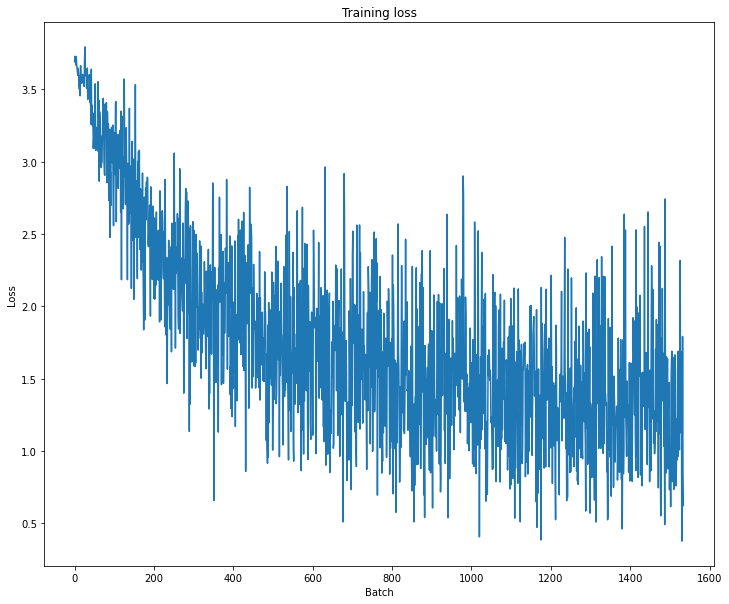

Loss на обучающей выборке: 1.78266
Процент правильных предсказаний на валидационной выборке: 67.04%


In [42]:
model, train_loss_set, valid_labels, valid_preds = train_model_epoch(model, train_loss_set =[])
epoch +=1

In [43]:
score = accuracy_score(valid_labels, valid_preds) * 100
if score > best_score:
    best_score = score
    torch.save(model.state_dict(), f"epoch_new_bert_dict_{epoch}.ckpt")
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    score
))
print(classification_report(valid_labels, valid_preds))

Процент правильных предсказаний на валидационной выборке: 67.04%
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       806
           1       0.89      0.68      0.77       131
           2       0.69      0.63      0.66        43
           3       0.67      0.19      0.29        43
           4       0.50      0.10      0.17        29
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         5
           7       0.80      0.57      0.67        21
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         4
          10       0.66      0.91      0.77       117
          11       0.61      0.95      0.75       126
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00        29
          14       0.00      0.00      0.00         8
          15       0.22      0.52      0.31        62
          16    

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# model1 = BertForSequenceClassification.from_pretrained(model_name, num_labels=40)
# PATH = "epoch_new_bert_dict_1.ckpt"
# model1.load_state_dict(torch.load(PATH))
# model1.eval()

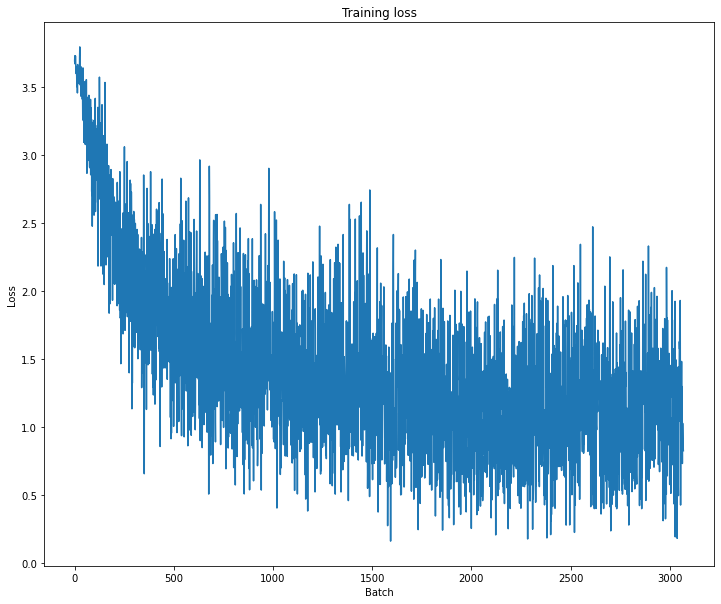

Loss на обучающей выборке: 1.12909
Процент правильных предсказаний на валидационной выборке: 67.91%
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       806
           1       0.94      0.60      0.73       131
           2       0.60      0.67      0.64        43
           3       0.50      0.28      0.36        43
           4       0.20      0.41      0.27        29
           5       0.00      0.00      0.00         7
           6       1.00      0.20      0.33         5
           7       0.81      0.62      0.70        21
           8       0.29      0.25      0.27         8
           9       0.00      0.00      0.00         4
          10       0.72      0.82      0.76       117
          11       0.69      0.93      0.79       126
          12       0.06      0.25      0.10         8
          13       0.50      0.03      0.06        29
          14       0.00      0.00      0.00         8
          15       0.28      0.68  

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
model, train_loss_set, valid_labels, valid_preds = train_model_epoch(model, train_loss_set)
epoch +=1

score = accuracy_score(valid_labels, valid_preds) * 100
if score > best_score:
    best_score = score
    torch.save(model.state_dict(), f"epoch_new_bert_dict_{epoch}.ckpt")
    print(classification_report(valid_labels, valid_preds))
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    score
))


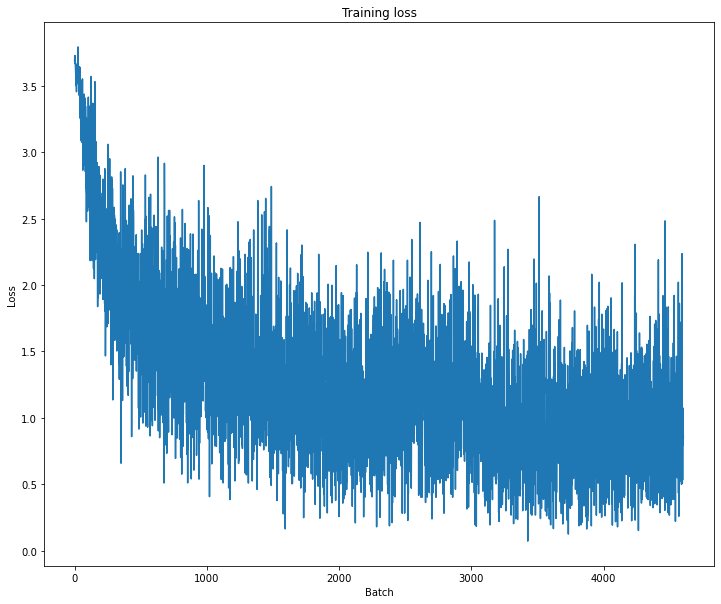

Loss на обучающей выборке: 0.91174
Процент правильных предсказаний на валидационной выборке: 66.35%
Процент правильных предсказаний на валидационной выборке: 66.35%


In [46]:
model, train_loss_set, valid_labels, valid_preds = train_model_epoch(model, train_loss_set)
epoch +=1

score = accuracy_score(valid_labels, valid_preds) * 100
if score > best_score:
    best_score = score
    torch.save(model.state_dict(), f"epoch_new_bert_dict_{epoch}.ckpt")
    print(classification_report(valid_labels, valid_preds))
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    score
))

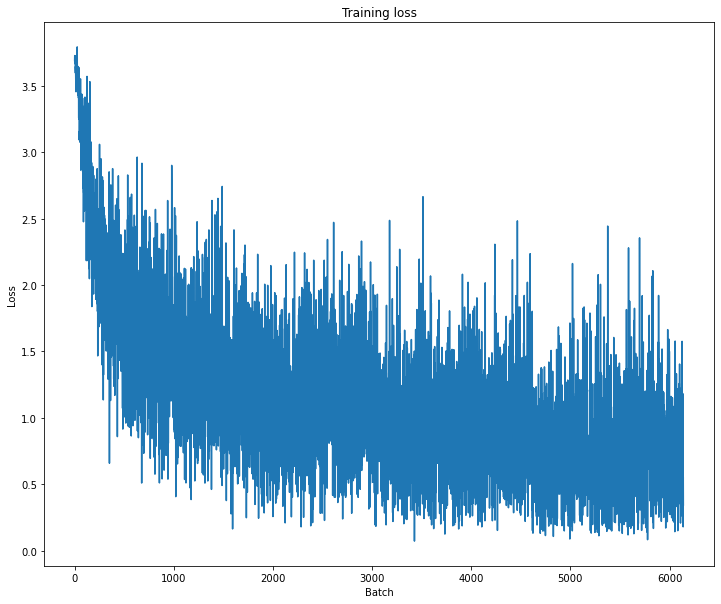

Loss на обучающей выборке: 0.74829
Процент правильных предсказаний на валидационной выборке: 69.06%
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       806
           1       0.88      0.72      0.79       131
           2       0.43      0.77      0.55        43
           3       0.50      0.07      0.12        43
           4       0.18      0.34      0.24        29
           5       0.00      0.00      0.00         7
           6       0.50      1.00      0.67         5
           7       0.81      0.62      0.70        21
           8       0.30      0.38      0.33         8
           9       0.00      0.00      0.00         4
          10       0.64      0.93      0.76       117
          11       0.66      0.87      0.75       126
          12       0.10      0.62      0.17         8
          13       0.15      0.07      0.10        29
          14       0.00      0.00      0.00         8
          15       0.28      0.55  

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
model, train_loss_set, valid_labels, valid_preds = train_model_epoch(model, train_loss_set)
epoch +=1

score = accuracy_score(valid_labels, valid_preds) * 100
if score > best_score:
    best_score = score
    torch.save(model.state_dict(), f"epoch_new_bert_dict_{epoch}.ckpt")
    print(classification_report(valid_labels, valid_preds))
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    score
))

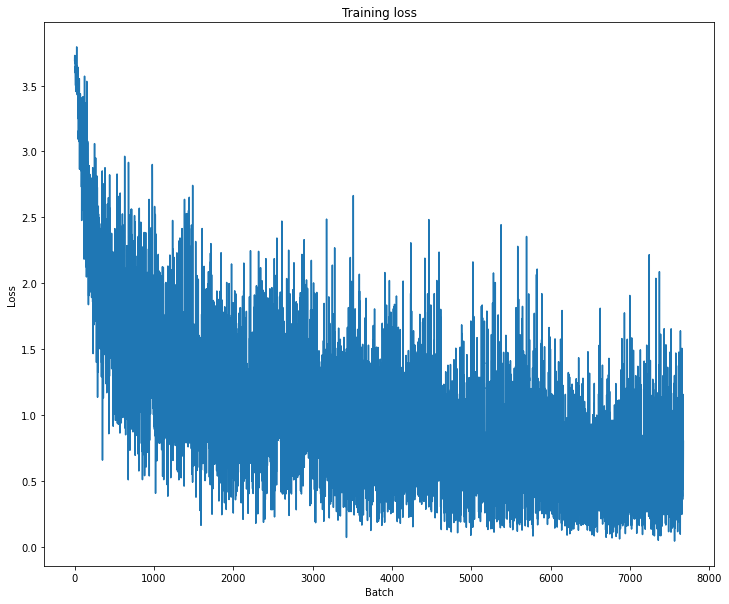

Loss на обучающей выборке: 0.62079
Процент правильных предсказаний на валидационной выборке: 67.91%
Процент правильных предсказаний на валидационной выборке: 67.91%


In [48]:
model, train_loss_set, valid_labels, valid_preds = train_model_epoch(model, train_loss_set)
epoch +=1

score = accuracy_score(valid_labels, valid_preds) * 100
if score > best_score:
    best_score = score
    torch.save(model.state_dict(), f"epoch_new_bert_dict_{epoch}.ckpt")
    print(classification_report(valid_labels, valid_preds))
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    score
))

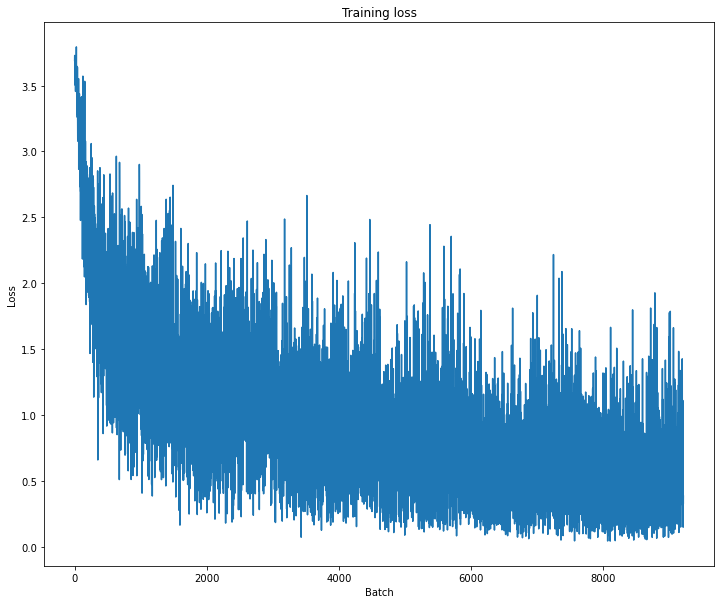

Loss на обучающей выборке: 0.53258
Процент правильных предсказаний на валидационной выборке: 67.80%
Процент правильных предсказаний на валидационной выборке: 67.80%


In [49]:
model, train_loss_set, valid_labels, valid_preds = train_model_epoch(model, train_loss_set)
epoch +=1

score = accuracy_score(valid_labels, valid_preds) * 100
if score > best_score:
    best_score = score
    torch.save(model.state_dict(), f"epoch_new_bert_dict_{epoch}.ckpt")
    print(classification_report(valid_labels, valid_preds))
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    score
))

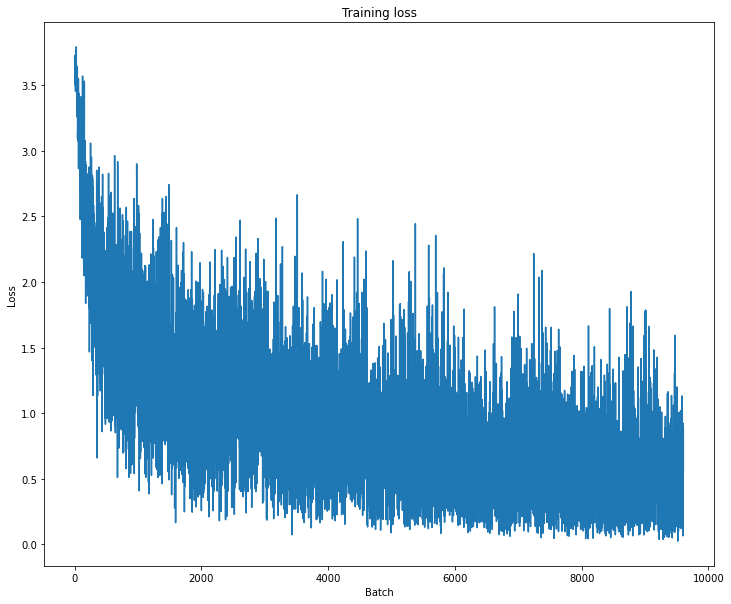

In [ ]:
model, train_loss_set, valid_labels, valid_preds = train_model_epoch(model, train_loss_set)
epoch +=1

score = accuracy_score(valid_labels, valid_preds) * 100
if score > best_score:
    best_score = score
    torch.save(model.state_dict(), f"epoch_new_bert_dict_{epoch}.ckpt")
    print(classification_report(valid_labels, valid_preds))
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    score
))

In [ ]:
model, train_loss_set, valid_labels, valid_preds = train_model_epoch(model, train_loss_set)
epoch +=1

score = accuracy_score(valid_labels, valid_preds) * 100
if score > best_score:
    best_score = score
    torch.save(model.state_dict(), f"epoch_new_bert_dict_{epoch}.ckpt")
    print(classification_report(valid_labels, valid_preds))
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    score
))

In [ ]:
model, train_loss_set, valid_labels, valid_preds = train_model_epoch(model, train_loss_set)
epoch +=1

score = accuracy_score(valid_labels, valid_preds) * 100
if score > best_score:
    best_score = score
    torch.save(model.state_dict(), f"epoch_new_bert_dict_{epoch}.ckpt")
    print(classification_report(valid_labels, valid_preds))
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    score
))

# Оценка качества на отложенной выборке

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=128,
    dtype="long",
    truncating="post",
    padding="post"
)

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [ ]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [60]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 68.19%


In [61]:
from sklearn.metrics import classification_report, accuracy_score

In [62]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       806
           1       0.84      0.71      0.77       131
           2       0.65      0.65      0.65        43
           3       0.45      0.21      0.29        43
           4       0.31      0.31      0.31        29
           5       0.00      0.00      0.00         7
           6       0.33      1.00      0.50         5
           7       0.65      0.62      0.63        21
           8       0.30      0.38      0.33         8
           9       1.00      0.25      0.40         4
          10       0.71      0.87      0.78       117
          11       0.66      0.87      0.75       126
          12       0.06      0.50      0.11         8
          13       0.75      0.41      0.53        29
          14       0.50      0.38      0.43         8
          15       0.29      0.35      0.32        62
          16       0.25      0.78      0.37        18
          17       0.56    

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
1+1

2